In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split

In [2]:
def load_data():
    column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num', 
    'marital_status', 'occupation', 'relationship', 'race', 
    'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 
    'native_country', 'income']
    
    train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    train_data = pd.read_csv(train_url, names=column_names, sep=',', skipinitialspace=True)
    
    test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'
    test_data = pd.read_csv(test_url, names=column_names, sep=',', skipinitialspace=True)
    
    return train_data, test_data

In [3]:
train_data, test_data = load_data()

In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
test_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


We are predicting income based off of race, sex, and education

In [6]:
X = ['age', 'education_num']  # covariates
A = 'sex'                     # sensitive attribute
W = X + [A]                   # features
Y = 'income'                  # outcome
columns = W + [Y]             # all variables

train = train_data[columns]
test = test_data[columns]

In [7]:
train.dtypes, test.dtypes

(age               int64
 education_num     int64
 sex              object
 income           object
 dtype: object,
 age               object
 education_num    float64
 sex               object
 income            object
 dtype: object)

In [8]:
# Outcome
print(train[Y].value_counts(dropna=False))
print(test[Y].value_counts(dropna=False))

income
<=50K    24720
>50K      7841
Name: count, dtype: int64
income
<=50K.    12435
>50K.      3846
NaN           1
Name: count, dtype: int64


In [9]:
# Sensitve Attribute
print(train[A].value_counts(normalize=True, dropna=False))
print(train[A].value_counts(normalize=True, dropna=False))

sex
Male      0.669205
Female    0.330795
Name: proportion, dtype: float64
sex
Male      0.669205
Female    0.330795
Name: proportion, dtype: float64


In [10]:
# Sensitive atribute: sex, which is either 1 (minority class 'female') or 0 (majority class 'male')
# Income is what we want to predict - the result is a 1 if the income is greater than 50k and 0 otherwise
# The covariates are: 
# education num - number of years of education
# age - this is done by the decade
# Train data
train['income'] = train['income'].apply(lambda x: 1 if x == '>50K' else 0)
train['sex'] = train['sex'].map({'Male': 0, 'Female': 1})

# Test data
test.drop(index=0, inplace=True)
test.dropna(inplace=True)
test['age'] = test['age'].astype(int)
test['education_num'] = test['education_num'].astype(int)
test['income'] = test['income'].apply(lambda x: 1 if x == '>50K.' else 0)
test['sex'] = test['sex'].map({'Male': 0, 'Female': 1})

In [11]:
train.head()

,age,education_num,sex,income
0,39,13,0,0
1,50,13,0,0
2,38,9,0,0
3,53,7,0,0
4,28,13,1,0


In [12]:
test.head()

,age,education_num,sex,income
1,25,7,0,0
2,38,9,0,0
3,28,12,0,1
4,44,10,0,1
5,18,10,1,0


In [13]:
train.income.value_counts(), test.income.value_counts()

(income
 0    24720
 1     7841
 Name: count, dtype: int64,
 income
 0    12435
 1     3846
 Name: count, dtype: int64)

In [14]:
# Simulate decision variable - in this case we will determine if an idividual should receive a loan
def loan_decision(row):
    base_prob = 0.3 # baseline of getting a loan
    income_factor = 0.1*row['income']
    education_factor = 0.02*row['education_num']
    
    # Gender bias - making it unfair
    if row['sex'] == 0: # Male
        gender_bias = 0.2 
    else:
        gender_bias = 0
        
    loan_prob =  base_prob + income_factor + education_factor + gender_bias
    loan_prob = min(loan_prob, 1)
    
    return int(np.random.rand() < loan_prob)
    
train['loan_approved'] = train.apply(loan_decision, axis=1)
test['loan_approved'] = test.apply(loan_decision, axis=1)

print(train.head())

   age  education_num  sex  income  loan_approved
0   39             13    0       0              1
1   50             13    0       0              0
2   38              9    0       0              1
3   53              7    0       0              1
4   28             13    1       0              0


In [15]:
train['loan_approved'].value_counts()

loan_approved
1    21354
0    11207
Name: count, dtype: int64

In [16]:
train[train['loan_approved'] == 1]['sex'].value_counts()

sex
0    15908
1     5446
Name: count, dtype: int64

In [17]:
all_data = pd.concat([train, test], ignore_index=True)

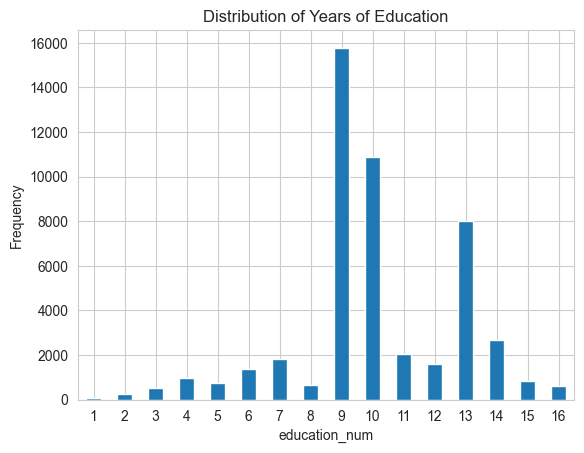

In [18]:
all_data['education_num'].value_counts().sort_index().plot(kind='bar', rot=0)
plt.ylabel('Frequency')
plt.title('Distribution of Years of Education')
plt.show()

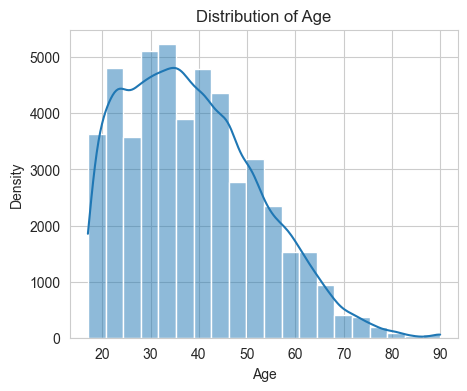

In [19]:
plt.figure(figsize=(5, 4))
sns.histplot(all_data['age'], kde=True, bins=20)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Age')
plt.show()

In [20]:
# Randomly split into Dlearn and Dtrain, consisting of 14,653 and 14,652 rows; and Dtest and Dvalidate, consisting of 9,768 and 9,769 rows
# Split data into Dlearn (14,653) and the remaining
Dlearn, remaining = train_test_split(all_data, train_size=14653, random_state=42)

# Split the remaining into Dtrain (14,652) and Dtest + Dvalidate (remaining rows)
Dtrain, temp = train_test_split(remaining, train_size=14652, random_state=42)

# Split temp into Dtest (9,768) and Dvalidate (9,769)
Dtest, Dvalidate = train_test_split(temp, train_size=9768, random_state=42)

# Verify the sizes
print("Dlearn:", Dlearn.shape)
print("Dtrain:", Dtrain.shape)
print("Dtest:", Dtest.shape)
print("Dvalidate:", Dvalidate.shape)

Dlearn: (14653, 5)
Dtrain: (14652, 5)
Dtest: (9768, 5)
Dvalidate: (9769, 5)


In [21]:
Dtrain.head()

,age,education_num,sex,income,loan_approved
32494,82,9,0,0,1
30876,53,9,0,0,0
44872,24,13,0,0,1
14731,37,10,1,0,1
11811,68,9,1,0,0


In [22]:
Dlearn["income"].value_counts(), Dtrain["income"].value_counts(), Dtest["income"].value_counts(), Dvalidate["income"].value_counts()

(income
 0    11179
 1     3474
 Name: count, dtype: int64,
 income
 0    11193
 1     3459
 Name: count, dtype: int64,
 income
 0    7450
 1    2318
 Name: count, dtype: int64,
 income
 0    7333
 1    2436
 Name: count, dtype: int64)

In [23]:
import os
os.makedirs("../data/adult", exist_ok=True)

Save a copy of the original data before binning and one-hot encoding (this will also be used for the counterfactual VAE):

In [24]:
Dlearn.to_csv("../data/adult/train_basis.csv", index=False)
Dtrain.to_csv("../data/adult/train_betahats.csv", index=False)
Dtest.to_csv("../data/adult/test.csv", index=False)
Dvalidate.to_csv("../data/adult/validate.csv", index=False)

Create indicator variables from `age` and `education_num` :

In [25]:
def encode_age(df):
    """Bin age to decades and one-hot encode it.
    
    Final columns: [age_decade=10, age_decade=20, ..., age_decade=60, age_decade=>=70]
    """
    age = pd.cut(df['age'], 
                 bins=[10, 20, 30, 40, 50, 60, 70, 100], right=False, 
                 labels=['10', '20', '30', '40', '50', '60', '>=70'])
    age = pd.get_dummies(age, prefix='age_decade', prefix_sep='=')
    return pd.concat([df, age.astype(int)], axis=1).drop(columns='age')

encode_age(Dlearn).columns

Index(['education_num', 'sex', 'income', 'loan_approved', 'age_decade=10',
       'age_decade=20', 'age_decade=30', 'age_decade=40', 'age_decade=50',
       'age_decade=60', 'age_decade=>=70'],
      dtype='object')

In [26]:
def encode_education(df):
    """Bin and one-hot encode education_num.
    
    Final columns: [education_years=<6, education_years=6, ..., education_years=12, education_years=>12]
    """
    education_num = pd.cut(df['education_num'], 
                           bins=[0, 6, 7, 8, 9, 10, 11, 12, 13, 100], right=False,
                           labels=['<6', '6', '7', '8', '9', '10', '11', '12', '>12'])
    education_ohe = pd.get_dummies(education_num, prefix='education_years', prefix_sep='=')
    return pd.concat([df, education_ohe.astype(int)], axis=1).drop(columns='education_num')
    
encode_education(Dlearn).columns

Index(['age', 'sex', 'income', 'loan_approved', 'education_years=<6',
       'education_years=6', 'education_years=7', 'education_years=8',
       'education_years=9', 'education_years=10', 'education_years=11',
       'education_years=12', 'education_years=>12'],
      dtype='object')

In [27]:
Dlearn = encode_education(encode_age(Dlearn))
Dtrain = encode_education(encode_age(Dtrain))
Dtest = encode_education(encode_age(Dtest))
Dvalidate = encode_education(encode_age(Dvalidate))

In [28]:
Dlearn.columns

Index(['sex', 'income', 'loan_approved', 'age_decade=10', 'age_decade=20',
       'age_decade=30', 'age_decade=40', 'age_decade=50', 'age_decade=60',
       'age_decade=>=70', 'education_years=<6', 'education_years=6',
       'education_years=7', 'education_years=8', 'education_years=9',
       'education_years=10', 'education_years=11', 'education_years=12',
       'education_years=>12'],
      dtype='object')

Save the data in the format that will be used with the FADE predictors:

In [29]:
Dlearn.to_csv("../data/adult/train_basis_ohe.csv", index=False)
Dtrain.to_csv("../data/adult/train_betahats_ohe.csv", index=False)
Dtest.to_csv("../data/adult/test_ohe.csv", index=False)
Dvalidate.to_csv("../data/adult/validate_ohe.csv", index=False)